# Ames House Price Predictions

## Initiation and Data Preprocessing

### Import Packages and Files

In [1]:
%%time

## import packages

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

sns.set_style('darkgrid')
sns.color_palette('Paired')

%matplotlib inline

CPU times: user 902 ms, sys: 169 ms, total: 1.07 s
Wall time: 1.13 s


In [2]:
%%time

## import files

# read files
df_train_raw = pd.read_csv('train.csv')
df_test_raw = pd.read_csv('test.csv')

CPU times: user 35.1 ms, sys: 4.97 ms, total: 40.1 ms
Wall time: 38.8 ms


In [3]:
%%time

## defining reusable functions

# create a function to analyze columns

def feature_analysis(dataframe):
    
    # include a column for dtypes of each feature
    feature_analysis_df = pd.DataFrame(dataframe.dtypes)
    feature_analysis_df.columns = ['dtypes']
    
    # include a column for number of unique values of each feature
    feature_analysis_df['nunique'] = 0
    for feat in feature_analysis_df.index:
        feature_analysis_df.loc[feat,'nunique'] = len(dataframe.loc[:,feat].unique())
        
    # include a column for number of unique values of each feature    
    feature_analysis_df['isnull'] = 0
    for feat in feature_analysis_df.index:
        feature_analysis_df.loc[feat,'isnull'] = dataframe.loc[:,feat].isnull().sum(axis = 0)
        
    # print dataset characteristics
    print('\nDataset Characteristics \n')
    print('rows:', dataframe.shape[0])
    print('columns:', dataframe.shape[1])
    print(feature_analysis_df)
    print()
    
    
## a function to calculate rmse for model evaluation

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


### Data Exploration and Cleaning

#### Selecting Useful Variables

In [4]:
## analyze raw dataset features: datatypes, null values, number of unique values
#feature_analysis(df_train_raw)
#df_train.info()

In [5]:
%%time

## analyzing continuous variables

# display continuous variables
# print(df_train_raw.columns[df_train_raw.dtypes == 'int64'])

# isolating continuous variables
df_train_raw_continuous = df_train_raw[list(df_train_raw.columns[df_train_raw.dtypes == 'int64'])]

# checking descriptive statistics
# df_train_raw_continuous.describe().T

# identifying continuous variables with highest correlation to the target
print(df_train_raw_continuous.corr()['SalePrice'].apply(abs).sort_values(ascending=False))


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64
CPU times: user 7.29 ms, sys: 1.73 ms, total: 9.02 ms
Wall

In [6]:
%%time

## selecting features relevant to this project

# create a function to select columns from the raw data
def preliminary_variable_selection(dataframe):
    
    if 'SalePrice' in dataframe.columns:
        selected_variables = dataframe.loc[
                                       dataframe['SalePrice'].notnull()][[
                                       'OverallQual', 'GrLivArea', 'SalePrice']]
        
    else: #applies to test dataset which doesn't have target variable
        selected_variables = dataframe[['OverallQual', 'GrLivArea']]
        
    return selected_variables

# apply function to raw data
df_train = preliminary_variable_selection(df_train_raw)
df_test = preliminary_variable_selection(df_test_raw)

CPU times: user 4.49 ms, sys: 1.29 ms, total: 5.79 ms
Wall time: 5.3 ms


In [7]:
%%time

## analyze dataset features: datatypes, null values, number of unique values

feature_analysis(df_train)


Dataset Characteristics 

rows: 1460
columns: 3
            dtypes  nunique  isnull
OverallQual  int64       10       0
GrLivArea    int64      861       0
SalePrice    int64      663       0

CPU times: user 9.98 ms, sys: 1.36 ms, total: 11.3 ms
Wall time: 11.3 ms


In [8]:
%%time

## preparing separate dataframe for plotting training data

df_train_plot = df_train.copy()

CPU times: user 122 µs, sys: 10 µs, total: 132 µs
Wall time: 126 µs


## Exploratory Data Analysis

### Univariate and Bivariate Data Analysis

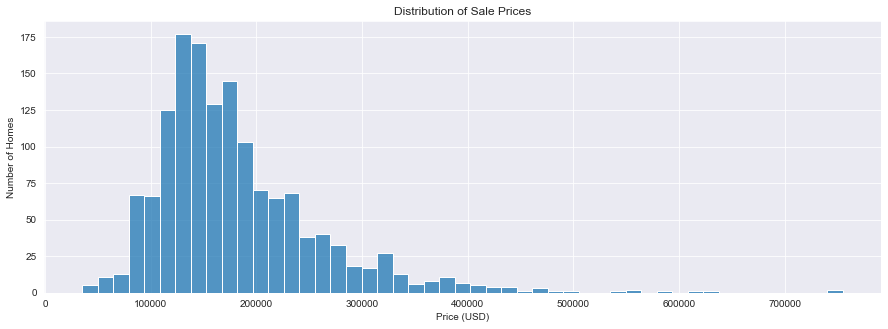

In [9]:

## potting the distribution of the target variable

plt.figure(figsize=(15,5))
ax = sns.histplot(x='SalePrice', data=df_train_plot)
ax.set_title('Distribution of Sale Prices')
ax.set_xlabel('Price (USD)')
ax.set_ylabel('Number of Homes')
plt.show()

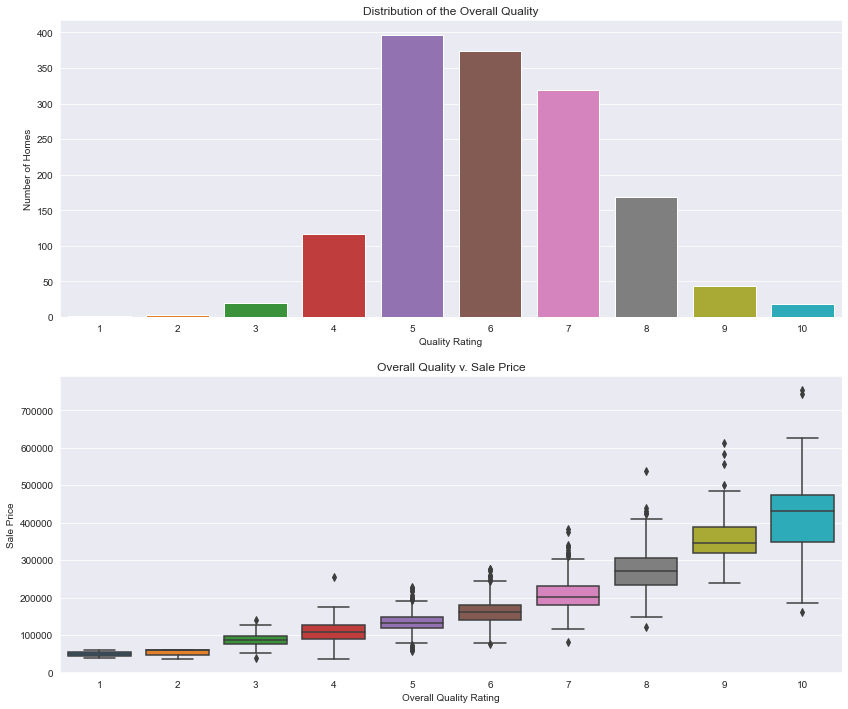

CPU times: user 580 ms, sys: 22.3 ms, total: 602 ms
Wall time: 604 ms


In [10]:
%%time

## potting the distribution of the overall quality and target variables

fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the distribution of the overall quality of the homes
plt.subplot(2, 1, 1)
ax[0] = sns.countplot(x='OverallQual', data=df_train_plot)
ax[0].set_title('Distribution of the Overall Quality')
ax[0].set_xlabel('Quality Rating')
ax[0].set_ylabel('Number of Homes')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(2, 1, 2)
ax[1] = sns.boxplot(data=df_train_plot, x="OverallQual", y="SalePrice" )
ax[1].set_title('Overall Quality v. Sale Price')
ax[1].set_xlabel('Overall Quality Rating')
ax[1].set_ylabel('Sale Price')

plt.show()

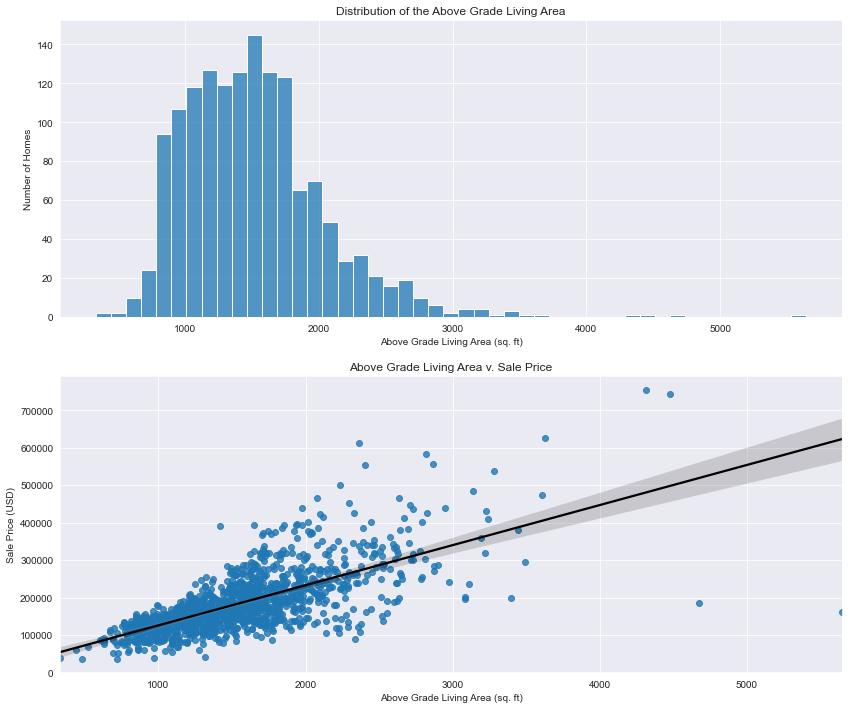

CPU times: user 2.1 s, sys: 98.8 ms, total: 2.2 s
Wall time: 968 ms


In [11]:
%%time

## potting the distribution of the above grade living area and target variables

fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the distribution of the above grade living area of the homes
plt.subplot(2, 1, 1)
ax[0] = sns.histplot(x='GrLivArea', data=df_train_plot)
ax[0].set_title('Distribution of the Above Grade Living Area')
ax[0].set_xlabel('Above Grade Living Area (sq. ft)')
ax[0].set_ylabel('Number of Homes')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(2, 1, 2)
ax[1] = sns.regplot(data=df_train_plot, x="GrLivArea", y="SalePrice",line_kws={'color':'black'} )
ax[1].set_title('Above Grade Living Area v. Sale Price')
ax[1].set_xlabel('Above Grade Living Area (sq. ft)')
ax[1].set_ylabel('Sale Price (USD)')

plt.show()

In [12]:
df_train_plot['log_overallquall'] = df_train_plot['OverallQual'].apply(math.log)

In [13]:
df_train_plot['log_grlivarea'] = df_train_plot['GrLivArea'].apply(math.log)

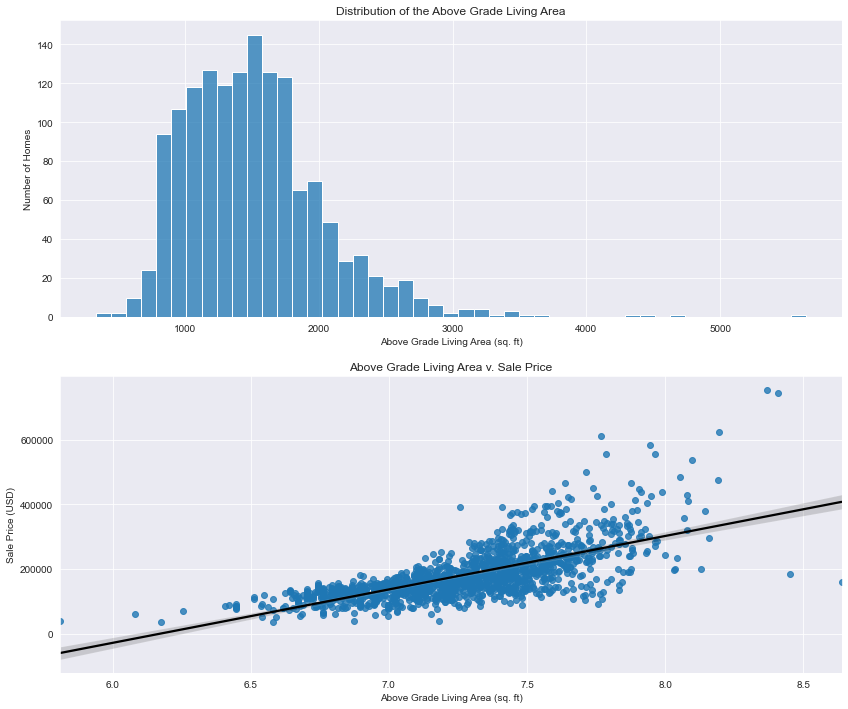

CPU times: user 2.01 s, sys: 78.9 ms, total: 2.09 s
Wall time: 833 ms


In [14]:
%%time

## potting the distribution of the above grade living area and target variables

fig, ax = plt.subplots(1,2, figsize=(14,12))

# potting the distribution of the above grade living area of the homes
plt.subplot(2, 1, 1)
ax[0] = sns.histplot(x='GrLivArea', data=df_train_plot)
ax[0].set_title('Distribution of the Above Grade Living Area')
ax[0].set_xlabel('Above Grade Living Area (sq. ft)')
ax[0].set_ylabel('Number of Homes')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(2, 1, 2)
ax[1] = sns.regplot(data=df_train_plot, x="log_grlivarea", y="SalePrice",line_kws={'color':'black'} )
ax[1].set_title('Above Grade Living Area v. Sale Price')
ax[1].set_xlabel('Above Grade Living Area (sq. ft)')
ax[1].set_ylabel('Sale Price (USD)')

plt.show()

### Multivariate Data Analysis

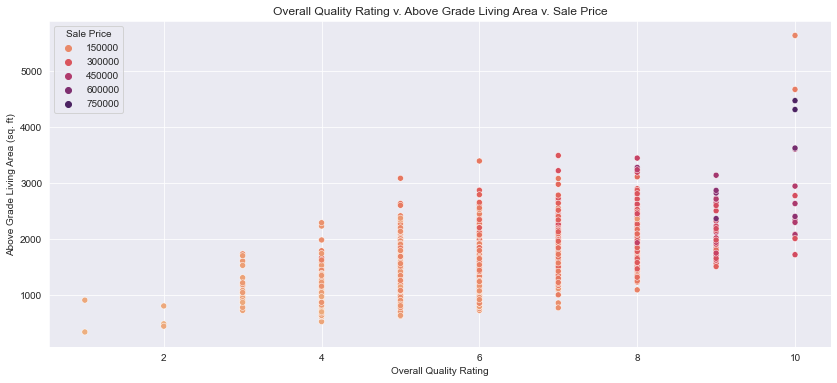

CPU times: user 383 ms, sys: 16.4 ms, total: 400 ms
Wall time: 401 ms


In [15]:
%%time

## potting the distribution of sales prices in relation to the above ground living area ang overall quality rating

palette = sns.color_palette('flare', as_cmap=True)

fig, ax = plt.subplots(1,1, figsize=(14,6))

ax = sns.scatterplot(
     data=df_train_plot.rename(columns={"SalePrice": "Sale Price"}),
     x="OverallQual", y="GrLivArea", hue='Sale Price', palette=palette )
ax.set_title('Overall Quality Rating v. Above Grade Living Area v. Sale Price')
ax.set_xlabel('Overall Quality Rating')
ax.set_ylabel('Above Grade Living Area (sq. ft)')

plt.show()

### Correlation of Variables

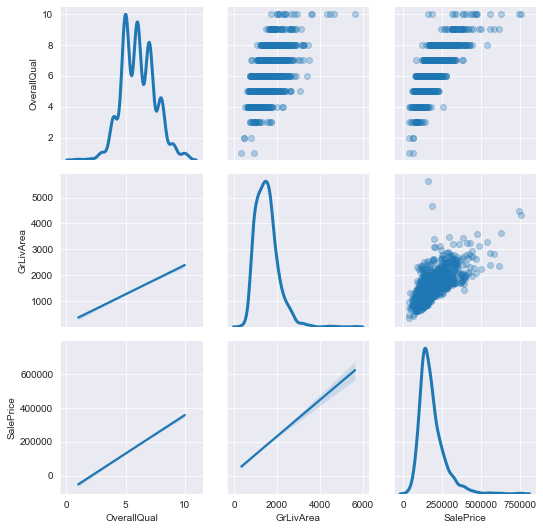

CPU times: user 4.63 s, sys: 137 ms, total: 4.76 s
Wall time: 2.16 s


In [16]:
%%time

## Creating Scatterplot Matrix with Sample of Original DataFrame

# Store Samples of DataFrame for Visualization
df_sample = df_train

# Declare Pairgrid
g = sns.PairGrid(df_sample.dropna(), diag_sharey=False)

# Scatterplot
g.map_upper(plt.scatter, alpha=.3)

# Fit Line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# KDE Plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

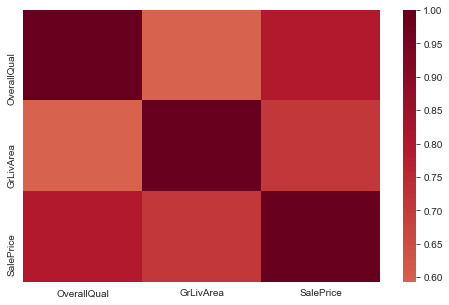

CPU times: user 204 ms, sys: 11.5 ms, total: 215 ms
Wall time: 220 ms


In [17]:
%%time

## Visualizing the Correlatedness of the Session variables

fig, ax = plt.subplots(figsize=(8,5))         
sns.heatmap(df_train.corr(), cmap='RdBu_r', center=0)
plt.show()

### Descriptive Statistics and Boxplots

In [18]:
%%time

## Descriptive Statistics

df_train.describe().T

CPU times: user 11.3 ms, sys: 1.48 ms, total: 12.8 ms
Wall time: 11.9 ms


,count,mean,std,min,25%,50%,75%,max
OverallQual,1460.0,6.099315,1.382997,1.0,5.0,6.0,7.00,10.0
GrLivArea,1460.0,1515.463699,525.480383,334.0,1129.5,1464.0,1776.75,5642.0
SalePrice,1460.0,180921.195890,79442.502883,34900.0,129975.0,163000.0,214000.00,755000.0


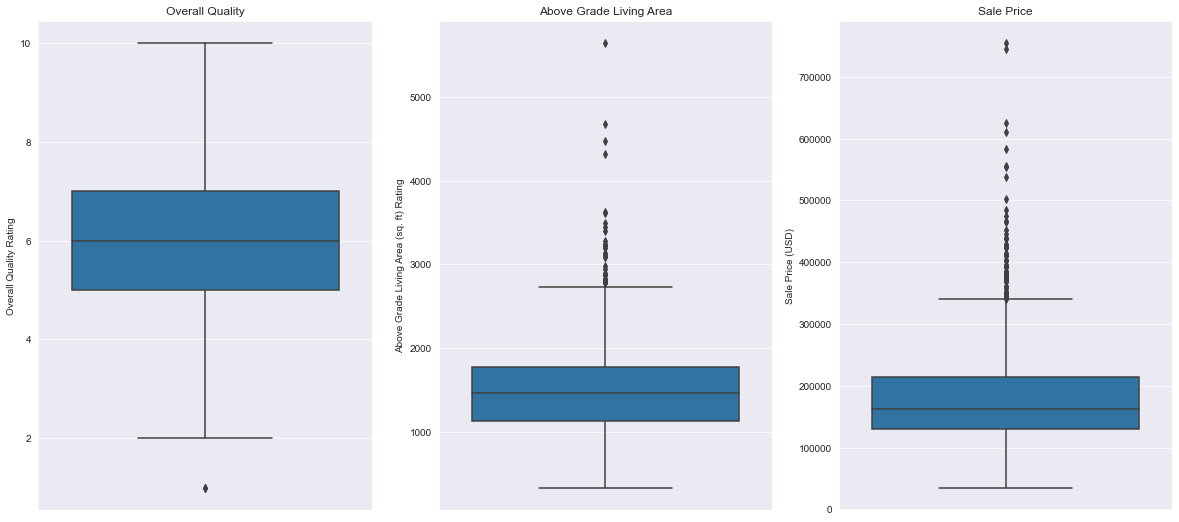

CPU times: user 426 ms, sys: 16.4 ms, total: 443 ms
Wall time: 444 ms


In [19]:
%%time

## potting the distribution of the overall quality and target variables

fig, ax = plt.subplots(1,2, figsize=(15,9))

# potting the distribution of the overall quality of the homes
plt.subplot(1, 3, 1)
ax[0] = sns.boxplot(y='OverallQual', data=df_train_plot)
ax[0].set_title('Overall Quality')
ax[0].set_ylabel('Overall Quality Rating')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(1, 3, 2)
ax[1] = sns.boxplot( y="GrLivArea", data=df_train_plot )
ax[1].set_title('Above Grade Living Area')
ax[1].set_ylabel('Above Grade Living Area (sq. ft) Rating')

# potting the distribution of the target variable in relation to overall quality
plt.subplot(1, 3, 3)
ax[1] = sns.boxplot( y="SalePrice", data=df_train_plot )
ax[1].set_title('Sale Price')
ax[1].set_ylabel('Sale Price (USD)')

plt.subplots_adjust(left=-.15)
plt.show()

## Preparing the Data For Modeling

### Creating Training and Validation Sets

In [20]:
%%time

## Establish Feature and Outcome Variables to be Used for Modeling Based on Original Features

x = df_train.drop('SalePrice',1)
y = df_train['SalePrice']

CPU times: user 877 µs, sys: 38 µs, total: 915 µs
Wall time: 907 µs


In [21]:
%%time

## Train Test Split the Feature and Outcome Variables

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=20)

CPU times: user 1.96 ms, sys: 928 µs, total: 2.88 ms
Wall time: 2.11 ms


### Feature Engineering

In [22]:
%%time

## isolate target and original variables 
## for feature engineering


x_train_original_features = x_train
x_val_original_features = x_val

df_test_original_features = df_test

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [23]:
%%time

## create interaction features and polynomial features (max order of 2) for every combination of features

def engineer_interactions(dataframe):
    
    poly = PolynomialFeatures().fit(dataframe)
    
    new_dataframe = pd.DataFrame(poly.transform(dataframe), 
                                 columns=poly.get_feature_names(input_features=dataframe.columns)).drop('1',1)
    
    return new_dataframe

x_train_features = engineer_interactions(x_train)
x_val_features = engineer_interactions(x_val)


df_test_features = engineer_interactions(df_test).drop(df_test_original_features.columns,1)


CPU times: user 9.01 ms, sys: 2.11 ms, total: 11.1 ms
Wall time: 9.73 ms


In [24]:
%%time

## create ordinal (numeric) features by binning continuous features

# training set

ord_bins_2 = KBinsDiscretizer(n_bins=2, encode='ordinal').fit(x_train_features)
x_train_features_ord_bins_2 = pd.DataFrame(
                                ord_bins_2.transform(x_train_features), 
                                columns=x_train_features.columns+'_ord_bins_2')

ord_bins_3 = KBinsDiscretizer(n_bins=3, encode='ordinal').fit(x_train_features)
x_train_features_ord_bins_3 = pd.DataFrame(
                                ord_bins_3.transform(x_train_features), 
                                columns=x_train_features.columns+'_ord_bins_3')

ord_bins_4 = KBinsDiscretizer(n_bins=4, encode='ordinal').fit(x_train_features)
x_train_features_ord_bins_4 = pd.DataFrame(
                                ord_bins_4.transform(x_train_features), 
                                columns=x_train_features.columns+'_ord_bins_4')

ord_bins_8 = KBinsDiscretizer(n_bins=8, encode='ordinal').fit(x_train_features)
x_train_features_ord_bins_8 = pd.DataFrame(
                                ord_bins_8.transform(x_train_features), 
                                columns=x_train_features.columns+'_ord_bins_8')

x_train_features = x_train_features.join([x_train_features_ord_bins_2, 
                                          x_train_features_ord_bins_3, 
                                          x_train_features_ord_bins_4, 
                                          x_train_features_ord_bins_8])

CPU times: user 16 ms, sys: 1.87 ms, total: 17.9 ms
Wall time: 16.8 ms


/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [25]:

%%time

## create ordinal (numeric) features by binning continuous features

# validation set

x_val_features_ord_bins_2 = pd.DataFrame(
                                ord_bins_2.transform(x_val_features), 
                                columns=x_val_features.columns+'_ord_bins_2')


ord_bins_3 = KBinsDiscretizer(n_bins=3, encode='ordinal').fit(x_val_features)
x_val_features_ord_bins_3 = pd.DataFrame(
                                ord_bins_3.transform(x_val_features), 
                                columns=x_val_features.columns+'_ord_bins_3')

ord_bins_4 = KBinsDiscretizer(n_bins=4, encode='ordinal').fit(x_val_features)
x_val_features_ord_bins_4 = pd.DataFrame(
                                ord_bins_4.transform(x_val_features), 
                                columns=x_val_features.columns+'_ord_bins_4')

ord_bins_8 = KBinsDiscretizer(n_bins=8, encode='ordinal').fit(x_val_features)
x_val_features_ord_bins_8 = pd.DataFrame(
                                ord_bins_8.transform(x_val_features), 
                                columns=x_val_features.columns+'_ord_bins_8')

x_val_features = x_val_features.join([x_val_features_ord_bins_2, 
                                      x_val_features_ord_bins_3, 
                                      x_val_features_ord_bins_4, 
                                      x_val_features_ord_bins_8])

CPU times: user 14.1 ms, sys: 2.3 ms, total: 16.4 ms
Wall time: 14.8 ms


/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/Users/Amechi/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [28]:
%%time

## finalize data for modeling

x_train = x_train_features
x_val = x_val_features

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


In [ ]:
identifying features through model coefficients

In [ ]:
recev or similar feature selection

In [ ]:
make strings from engineered bins

In [ ]:
original ordinal features to make strings

In [ ]:
test set eveluation and visualization

### Additional Data Cleaning

Removing Extreme Values

## Baseline Modeling and Evaluation

### Linear Regression

#### Data Preprocessing

Mathematical Transformations

#### Feature Selection

Analysis of Variance

#### Creating and Evaluating the Model 

In [29]:
%%time

## train and fit model

regr = LinearRegression().fit(x_train, y_train)


CPU times: user 19.3 ms, sys: 6.62 ms, total: 25.9 ms
Wall time: 17.8 ms


In [31]:
%%time

## Model Evaluation

print('Train Set Evaluation')
print()

print("R squared score:\n" + str(regr.score(x_train, y_train))+'\n')

print('RMSE: ' + str(rmse(regr.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, regr.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(regr, x_train, y_train, cv=5))+'\n')
print()

Train Set Evaluation

R squared score:
0.7799461209689984

RMSE: 36842.70746913577

MAE: 25715.472698005604

cross validation:
[0.74211305 0.76902434 0.74909464 0.76679696 0.7718669 ]


CPU times: user 96.9 ms, sys: 4.89 ms, total: 102 ms
Wall time: 28.2 ms


In [32]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()

print("R squared score:\n" + str(regr.score(x_val, y_val))+'\n')

print('RMSE: ' + str(rmse(regr.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, regr.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.7776690045405463

RMSE: 39042.16632156241

MAE: 26280.928390235862

CPU times: user 3.78 ms, sys: 804 µs, total: 4.59 ms
Wall time: 3.87 ms


### Decision Tree

#### Data Preprocessing

Mathematical Transformations

#### Feature Selection

Analysis of Variance

#### Creating and Evaluating the Model 

In [33]:
%%time

## train and fit model

decision_tree = DecisionTreeRegressor().fit(x_train, y_train)

CPU times: user 7.02 ms, sys: 1.35 ms, total: 8.36 ms
Wall time: 7.07 ms


In [34]:
%%time

## Model Evaluation

print('Train Set Evaluation')
print()

print("R squared score:\n" + str(decision_tree.score(x_train, y_train))+'\n')

print('RMSE: ' + str(rmse(decision_tree.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, decision_tree.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(decision_tree, x_train, y_train, cv=5))+'\n')
print()

Train Set Evaluation

R squared score:
0.980399832671382

RMSE: 10995.548867468751

MAE: 4017.0228514350943

cross validation:
[0.43919565 0.45552757 0.67434535 0.50373656 0.58948582]


CPU times: user 43 ms, sys: 2.22 ms, total: 45.2 ms
Wall time: 43.8 ms


In [35]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()

print("R squared score:\n" + str(decision_tree.score(x_val, y_val))+'\n')

print('RMSE: ' + str(rmse(decision_tree.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, decision_tree.predict(x_val))))
print()


Validation Set Evaluation

R squared score:
0.7025769756989266

RMSE: 45156.595711909766

MAE: 33021.9045580561

CPU times: user 4.63 ms, sys: 1.31 ms, total: 5.94 ms
Wall time: 4.68 ms


### Random Forest

#### Data Preprocessing

Mathematical Transformations

#### Feature Selection

Analysis of Variance

#### Creating and Evaluating the Model 

In [63]:
%%time

## train and fit model

rfr = RandomForestRegressor().fit(x_train, y_train)

CPU times: user 333 ms, sys: 9.14 ms, total: 342 ms
Wall time: 342 ms


In [64]:
%%time

## Model Evaluation

print('Train Set Evaluation')
print()

print("R squared score:\n" + str(rfr.score(x_train, y_train))+'\n')

print('RMSE: ' + str(rmse(rfr.predict(x_train), y_train)))
print()
print('MAE: ' + str(mean_absolute_error(y_train, rfr.predict(x_train))))
print()
print("cross validation:\n" + str(cross_val_score(rfr, x_train, y_train, cv=5))+'\n')
print()

Train Set Evaluation

R squared score:
0.9440574462938888

RMSE: 18576.255136063748

MAE: 12357.648723775463

cross validation:
[0.62668115 0.64252575 0.7391332  0.68484747 0.70532717]


CPU times: user 1.54 s, sys: 40.6 ms, total: 1.58 s
Wall time: 1.59 s


In [65]:
%%time

## Model Evaluation

print('Validation Set Evaluation')
print()

print("R squared score:\n" + str(rfr.score(x_val, y_val))+'\n')

print('RMSE: ' + str(rmse(rfr.predict(x_val), y_val)))
print()
print('MAE: ' + str(mean_absolute_error(y_val, rfr.predict(x_val))))
print()

Validation Set Evaluation

R squared score:
0.7761930619521695

RMSE: 39171.542520115356

MAE: 28915.091648307425

CPU times: user 41.5 ms, sys: 2.01 ms, total: 43.5 ms
Wall time: 41.9 ms


## Final Modeling and Evaluation

## Final Analysis and Conclusion

### Analyze Model Effect on Unlabeled Data

### Analysis of Feature Importance

### Conclusion and Discussion

## Resources